In [125]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import copy
import pandas as pd
import random
import pickle
import importlib

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

from EEGNet import *
# importlib.reload(EEGNet)

In [126]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [127]:
# import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


## Dataset

In [128]:
class EarthquakeData(Dataset):
    def __init__(self, h_path, d_path):
        self.c_path = h_path + d_path
        self.h_len = len(h_path)
    
    def __len__(self):
        return len(self.c_path)
    
    def __getitem__(self, idx):
        path = self.c_path[idx]

        if idx > self.h_len:
            y = 1
        else:
            y = 0
            
        X = np.loadtxt(path, delimiter=',', dtype=str).astype(np.float32)

        return X, y

In [113]:
data_directory = 'area1-all'
# second_data_directory = 'area3-all'
# third_data_directory = 'area3-all'

class1_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + data_directory + "/nonSSE/*.csv")
class2_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + data_directory + "/SSE/*.csv")


# class1_paths_second = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + second_data_directory + "/nonSSE/*.csv")
# class2_paths_second = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + second_data_directory + "/SSE/*.csv")

# class1_paths = class1_paths + class1_paths_second
# class2_paths = class2_paths + class2_paths_second

# class1_paths_third = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/" + third_data_directory + "/nonSSE/*.csv")
# class2_paths_third = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/"  + third_data_directory + "/SSE/*.csv")

# class1_paths = class1_paths + class1_paths_third
# class2_paths = class2_paths + class2_paths_third

print("Before Undersampling")
print("NonSSE:", len(class1_paths))
print("SSE:", len(class2_paths))

undersample = True
if undersample:
    if class1_paths > class2_paths:
        sampled = random.sample(range(len(class1_paths)), len(class2_paths))
        new_class1_paths = []
        for x in sampled:
            new_class1_paths.append(class1_paths[x])
        class1_paths = new_class1_paths

print(" ")
print("After Undersampling")
print("NonSSE:", len(class1_paths))
print("SSE:", len(class2_paths))


Before Undersampling
NonSSE: 10710
SSE: 5661
 
After Undersampling
NonSSE: 5661
SSE: 5661


In [114]:
dataset = EarthquakeData(class1_paths, class2_paths)

In [115]:
# Calculate size for each dataloader (60% training, 20% validation and testing)
total_len = len(dataset)
train_size = int(total_len * 0.6)
val_size = int(total_len * 0.2)
test_size = total_len - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
print(train_size, val_size, test_size)

batch_size = 8
dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)
print(len(dataloader), len(test_dataloader), len(val_dataloader))

6793 2264 2265
850 284 283


In [116]:
for features, labels in test_dataloader:
    print(features.shape)
    print("-------")
    print(labels)
    break;
    

torch.Size([8, 30, 58])
-------
tensor([0, 1, 1, 0, 0, 0, 0, 0])


## Model

In [117]:
num_chans = 30

# if filter:
#     num_chans = len(filter)

model = EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)

In [118]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [119]:
epochs = 100
# print(dataloader)
best_weights, accuracy_stats, loss_stats = train(model, optimizer, criterion, dataloader, 
                                                 val_dataloader, epochs=epochs, device=device)

Iteration: 0 / 850
Iteration: 100 / 850
Iteration: 200 / 850
Iteration: 300 / 850
Iteration: 400 / 850
Iteration: 500 / 850
Iteration: 600 / 850
Iteration: 700 / 850
Iteration: 800 / 850
Epoch 000: | Train Loss: 0.69882 | Val Loss: 0.69492 | Train Acc: 54.589 | Val Acc: 56.127
Iteration: 0 / 850
Iteration: 100 / 850
Iteration: 200 / 850
Iteration: 300 / 850
Iteration: 400 / 850
Iteration: 500 / 850
Iteration: 600 / 850
Iteration: 700 / 850
Iteration: 800 / 850
Epoch 001: | Train Loss: 0.68796 | Val Loss: 0.71123 | Train Acc: 56.678 | Val Acc: 52.551
Iteration: 0 / 850
Iteration: 100 / 850
Iteration: 200 / 850
Iteration: 300 / 850
Iteration: 400 / 850
Iteration: 500 / 850
Iteration: 600 / 850
Iteration: 700 / 850
Iteration: 800 / 850
Epoch 002: | Train Loss: 0.68563 | Val Loss: 0.69484 | Train Acc: 57.178 | Val Acc: 54.968
Iteration: 0 / 850
Iteration: 100 / 850
Iteration: 200 / 850
Iteration: 300 / 850
Iteration: 400 / 850
Iteration: 500 / 850
Iteration: 600 / 850
Iteration: 700 / 850


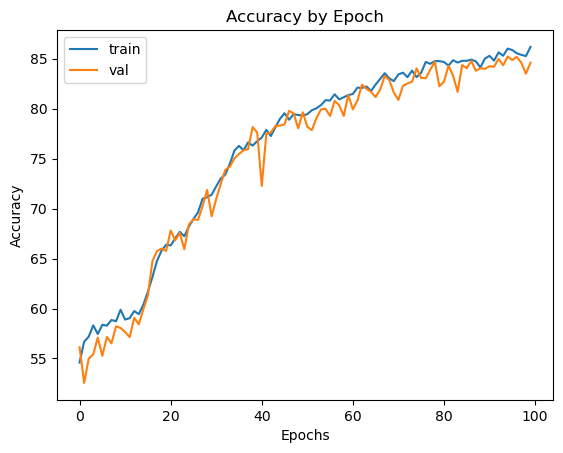

In [120]:
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
validation_accuracy = train_val_acc_df[train_val_acc_df['variable'] == "val"]
train_accuracy = train_val_acc_df[train_val_acc_df['variable'] == "train"]
train_accuracy
plt.plot(train_accuracy['epochs'], train_accuracy['value'])
plt.plot(validation_accuracy['epochs'], validation_accuracy['value'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy by Epoch")
plt.legend(["train", "val"])

In [121]:
test_loss = 0
test_acc = 0
i = 0
for test_features, test_labels in test_dataloader:
    test_features, test_labels = test_features.to(device), test_labels.to(device)
    # test_features = torch.unsqueeze(test_features, 1)
    test_features = test_features.float()
    test_labels = test_labels.float()
    # if (test_pred.size() == 8):
            # print(i)

    test_pred = model(test_features)
    test_pred = torch.squeeze(test_pred)
    # test_loss_item = criterion(test_pred, test_labels)
    test_acc_item = binary_acc(test_pred, test_labels)
    # test_loss += test_loss_item.item()
    test_acc += test_acc_item.item()

In [122]:
final_test_acc = test_acc/len(test_dataloader)
print("Testing Accuracy: ", final_test_acc)

Testing Accuracy:  84.54225352112677


In [123]:
folder_name = 'area1&2&3/'

directory_name = "/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/models/"

f_dict = directory_name+folder_name
print(f_dict)

if not os.path.exists(f_dict):
    os.makedirs(f_dict)

#best_weights, accuracy_stats, loss_stats

torch.save(model.state_dict(), f_dict+"area1_full_data.pth")

acc_file = open(f_dict+"accuracy_stats.obj", 'wb')
pickle.dump(accuracy_stats, acc_file)
acc_file.close()

loss_file = open(f_dict+"loss_stats.obj", 'wb')
pickle.dump(loss_stats, loss_file)
loss_file.close()

b_weights_file = open(f_dict+"best_weights.obj", "wb")
pickle.dump(best_weights, b_weights_file)
b_weights_file.close()

/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/models/area1&2&3/


In [124]:
# Example on how to open pickle files
pickle_in = open(f_dict+"accuracy_stats.obj", 'rb')
example_dict = pickle.load(pickle_in)
example_dict

{'train': [54.58941176470588,
  56.67764705882353,
  57.17764705882353,
  58.308235294117644,
  57.449411764705886,
  58.36705882352941,
  58.28470588235294,
  58.85176470588235,
  58.72470588235294,
  59.87647058823529,
  58.892941176470586,
  59.03529411764706,
  59.747058823529414,
  59.43882352941176,
  60.37529411764706,
  61.67411764705882,
  63.16,
  64.76470588235294,
  65.79176470588236,
  66.38705882352942,
  66.30823529411765,
  67.01882352941176,
  67.67176470588235,
  67.23294117647059,
  68.20588235294117,
  68.95647058823529,
  69.61411764705882,
  70.98588235294118,
  71.14,
  71.39647058823529,
  72.22941176470589,
  73.01764705882353,
  73.40235294117647,
  74.5,
  75.81058823529412,
  76.28235294117647,
  75.83176470588235,
  76.63176470588235,
  76.30823529411765,
  76.75411764705882,
  77.11294117647058,
  77.88588235294118,
  77.26705882352941,
  78.14470588235294,
  78.9929411764706,
  79.54705882352941,
  78.89764705882352,
  79.44705882352942,
  79.370588235294